In [6]:
import cv2
import numpy as np
import json
import matplotlib.pyplot as plt

In [7]:
def compute_affine(one, two):
    return cv2.getAffineTransform(np.float32(one), np.float32(two))

def warp_triangle(img, src, dst, size):
    M = compute_affine(src, dst)
    print(M)
    warped_triangle = cv2.warpAffine(img, M, (size[0], size[1]), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)
    return warped_triangle

def morph_images(imgA, imgB, pointsA, pointsB, midway_points, simplices):
    h, w, _ = imgA.shape
    morphed_img = np.zeros((h, w, 3), dtype=np.uint8)

    for tri_indices in simplices:
        triA = pointsA[tri_indices]
        triB = pointsB[tri_indices]
        tri_mid = midway_points[tri_indices]
        print(f"Processing triangle {tri_indices}")
        print("Triangle A Points:\n", triA)
        print("Triangle B Points:\n", triB)
        print("Midway Triangle Points:\n", tri_mid)

        r = cv2.boundingRect(np.float32([tri_mid]))
        print(f"Bounding Box for triangle {tri_indices}: {r}")
        
        triA_offset = triA - [r[0], r[1]]
        triB_offset = triB - [r[0], r[1]]
        tri_mid_offset = tri_mid - [r[0], r[1]]

        mask = np.zeros((r[3], r[2], 3), dtype=np.float32)
        cv2.fillConvexPoly(mask, np.int32(tri_mid_offset), (1.0, 1.0, 1.0), 16, 0)

        imgA_warped = warp_triangle(imgA, triA, tri_mid, (r[2], r[3]))
        imgB_warped = warp_triangle(imgB, triB, tri_mid, (r[2], r[3]))
        print(f"Warped Triangle A size: {imgA_warped.shape}, Triangle B size: {imgB_warped.shape}")
        blended_triangle = (imgA_warped + imgB_warped) / 2.0

        morphed_img[r[1]:r[1] + r[3], r[0]:r[0] + r[2]] = morphed_img[r[1]:r[1] + r[3], r[0]:r[0] + r[2]] * (1 - mask) + blended_triangle * mask
    
    return morphed_img

Processing triangle [47 49 54]
Triangle A Points:
 [[210 194]
 [202 805]
 [208 170]]
Triangle B Points:
 [[125  34]
 [157 829]
 [125  15]]
Midway Triangle Points:
 [[167.5 114. ]
 [179.5 817. ]
 [166.5  92.5]]
Bounding Box for triangle [47 49 54]: (166, 92, 14, 726)
[[ 2.28429986e-01  2.26308345e-02  1.15139321e+02]
 [-2.64179632e+00  1.11598303e+00  4.52276521e+02]]
[[-9.32565789e-01  5.26315789e-02  2.82281250e+02]
 [-6.14391447e+00  1.13157895e+00  8.43515625e+02]]
Warped Triangle A size: (726, 14, 3), Triangle B size: (726, 14, 3)
Processing triangle [51  7 49]
Triangle A Points:
 [[418 745]
 [524 703]
 [202 805]]
Triangle B Points:
 [[287 748]
 [497 808]
 [157 829]]
Midway Triangle Points:
 [[352.5 746.5]
 [510.5 755.5]
 [179.5 817. ]]
Bounding Box for triangle [51  7 49]: (179, 746, 332, 72)
[[-8.16371681e-01 -5.82227139e+00  5.03133555e+03]
 [-1.29092920e+00 -3.47234513e+00  3.87300553e+03]]
[[ 9.34220073e-01 -6.36436921e-01  5.60433656e+02]
 [-1.41112455e-01  6.43893591e-01  3.

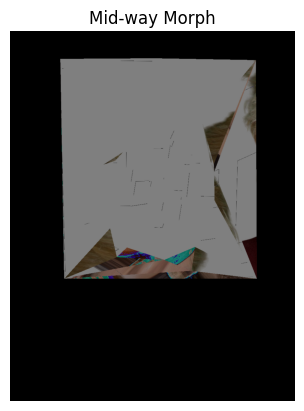

True

In [8]:
imgA = cv2.imread('images/me_cropped.png')
imgB = cv2.imread('images/ross.png')

# Load the triangulation and points from JSON
with open('data/triangles.json', 'r') as f:
    data = json.load(f)

midway_points = np.array(data['midway_points'])
simplices = np.array(data['simplices'])

with open('data/correspondance.json', 'r') as f:
    correspondance_data = json.load(f)

# Extract the points for image A and image B
pointsA = np.array(correspondance_data["im1Points"])
pointsB = np.array(correspondance_data["im2Points"])

# Compute the morphed image
morphed_img = morph_images(imgA, imgB, pointsA, pointsB, midway_points, simplices)
morphed_img_rgb = cv2.cvtColor(morphed_img, cv2.COLOR_BGR2RGB)

# Display the result using matplotlib
plt.imshow(morphed_img_rgb)
plt.axis('off')  # Turn off axis labels and ticks
plt.title("Mid-way Morph")
plt.show()

# Optionally save the result (you already have this line)
cv2.imwrite("images/midway_morph.png", morphed_img)

In [13]:
def compute_average_shape(pointsA, pointsB):
    # Calculate the average shape between two sets of points
    average_shape = (pointsA + pointsB) / 2
    return average_shape
    
with open('data/correspondance.json', 'r') as f:
    correspondance_data = json.load(f)

# Extract the points for image A and image B
pointsA = np.array(correspondance_data["im1Points"])
pointsB = np.array(correspondance_data["im2Points"])
midway_points = compute_average_shape(pointsA, pointsB)

In [16]:
midway_points

array([[504.5, 242.5],
       [388.5, 290.5],
       [309.5, 441.5],
       [310. , 467.5],
       [309.5, 530. ],
       [330.5, 651.5],
       [386.5, 714. ],
       [510.5, 755.5],
       [611.5, 712. ],
       [655. , 664.5],
       [675.5, 557. ],
       [674.5, 464. ],
       [673.5, 441. ],
       [636.5, 307.5],
       [504. , 337.5],
       [460.5, 413.5],
       [394.5, 400.5],
       [373.5, 400. ],
       [347. , 429.5],
       [508. , 422. ],
       [553.5, 411.5],
       [599.5, 405. ],
       [632.5, 408. ],
       [662.5, 431.5],
       [506. , 486. ],
       [467.5, 528.5],
       [456. , 557.5],
       [488. , 564.5],
       [508. , 538. ],
       [531.5, 566. ],
       [562. , 549. ],
       [538.5, 531.5],
       [417. , 456.5],
       [589. , 457.5],
       [556.5, 460.5],
       [625.5, 464. ],
       [450. , 460.5],
       [382. , 462. ],
       [378.5, 547.5],
       [629.5, 546.5],
       [511.5, 635. ],
       [512. , 616. ],
       [490. , 613. ],
       [538

In [17]:
pointsA

array([[465, 281],
       [381, 354],
       [352, 459],
       [352, 483],
       [345, 548],
       [362, 638],
       [411, 680],
       [524, 703],
       [602, 664],
       [641, 623],
       [651, 525],
       [627, 439],
       [622, 415],
       [562, 327],
       [475, 357],
       [441, 425],
       [401, 423],
       [381, 427],
       [364, 450],
       [492, 433],
       [534, 407],
       [567, 398],
       [590, 399],
       [614, 413],
       [498, 492],
       [473, 531],
       [466, 563],
       [491, 562],
       [505, 533],
       [526, 559],
       [548, 540],
       [529, 524],
       [419, 467],
       [563, 447],
       [541, 458],
       [590, 449],
       [443, 470],
       [390, 477],
       [398, 546],
       [607, 516],
       [520, 617],
       [518, 597],
       [498, 597],
       [535, 594],
       [457, 623],
       [530, 646],
       [578, 609],
       [210, 194],
       [754, 177],
       [202, 805],
       [776, 796],
       [418, 745],
       [559,